## Working with Data

Load data from NYC taxy dataset and work with it in Spark.

### Загружаем данные

Загружаем данные в папку data

In [75]:
# Загрузим 3 года данных.

import urllib.request

for year in range(2020, 2023):
    for month in range(1,13):
        url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet"
        local_file = f"./data/raw/yellow_tripdata_{year}-{month:02d}.parquet"
        urllib.request.urlretrieve(url, local_file)        

### Импортируем сессию для дальнейшей работы

In [2]:
from pyspark.sql import SparkSession

### Создаем сессию

In [3]:
spark = (
    SparkSession.builder
        .master("local")
        .appName("Word Count")
        .config("spark.some.config.option", "some-value")
        .getOrCreate()
)

### Получаем данные и файла

In [80]:
# Считываем данные из parquet, для примера взял его, т.к. уже содержит схему
# df = spark.read.parquet("./data/raw/*.parquet")

df = (
    spark
    .read
    .parquet("./data/raw/*.parquet")
    .withColumn("airport_fee", col("airport_fee").cast("double"))
)

# Можно читать из csv, json, text, jdbc
# df.read.csv(path, header=True, inferSchema=True)
# ...

# Также можно считать данные API и обернуть его в DataFrame. То есть Spark не будет подключаться к API, а возьмет результат.

### Запишем результат

In [89]:
from pyspark.sql.functions import col, input_file_name, regexp_extract
from pathlib import Path

# Получаем список всех Parquet файлов
paths = list(Path("data/raw/").glob("*.parquet"))

dfs = []
for path in paths:
    # Читаем каждый файл отдельно
    df_file = spark.read.parquet(str(path))
    
    # Приводим airport_fee к double
    df_file = df_file.withColumn("airport_fee", col("airport_fee").cast("double"))
    
    # Добавляем колонку с именем файла
    df_file = df_file.withColumn("filename", input_file_name())
    
    # Извлекаем год и месяц из имени файла
    df_file = df_file.withColumn(
        "year", 
        regexp_extract(col("filename"), r"yellow_tripdata_(\d{4})-\d{2}\.parquet", 1).cast("int")
    ).withColumn(
        "month", 
        regexp_extract(col("filename"), r"yellow_tripdata_\d{4}-(\d{2})\.parquet", 1).cast("int")
    )
    
    dfs.append(df_file)

# Объединяем все DataFrame
df = dfs[0]
for d in dfs[1:]:
    df = df.unionByName(d, allowMissingColumns=True)

# Сохраняем в partitioned Parquet
df.write.mode("overwrite") \
    .partitionBy("year", "month") \
    .parquet("data/nyc_taxi")

In [90]:
# Displays the content of the DataFrame to stdout
df.show(3)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------------------+----+-----+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|            filename|year|month|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------------------+----+-----+
|       1| 2020-03-01 00:31:13|  2020-03-01 01:01:42|            1.0|          4.7|       1

### Считаем количество строк

In [103]:
from pyspark.sql.functions import col

# Читаем все данные с учетом партиций
df = spark.read.parquet("data/nyc_taxi/")

# Считаем все строки
total_count = df.filter((col("year") == 2022) & (col("month") == 12)).count()

print(f"Total rows: {total_count}")

Total rows: 3399549


### Из плана задачи видно, что был считан только один файл, так как был фильтр на год и месяц.

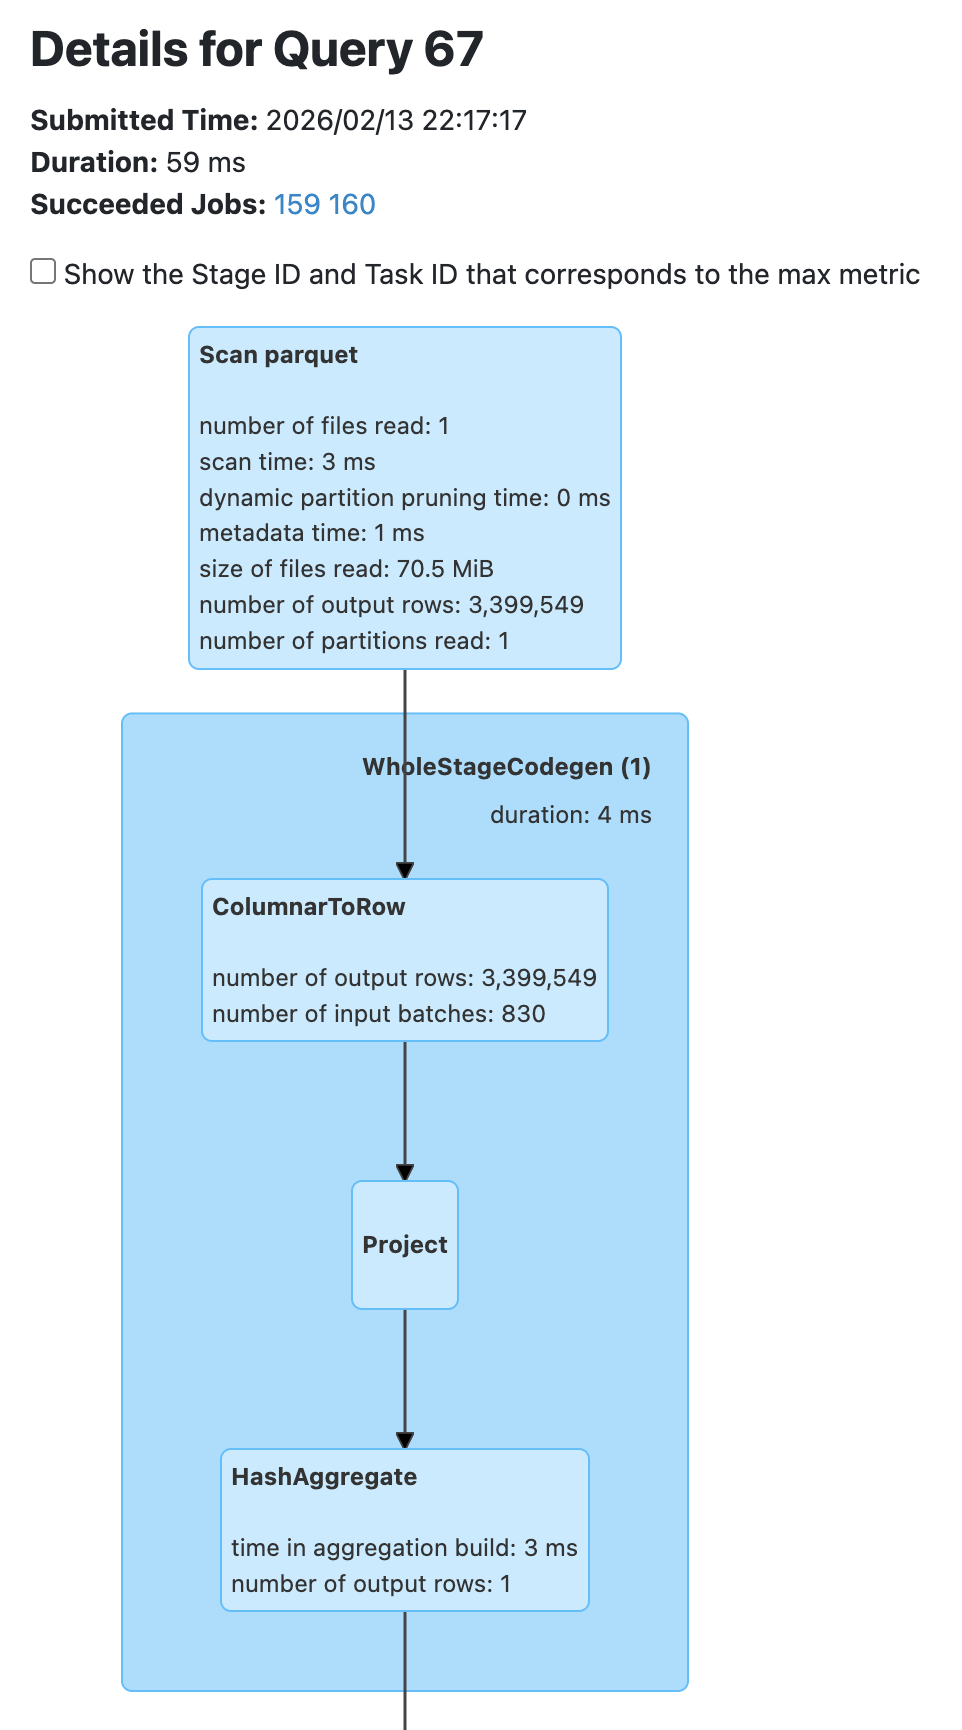

In [96]:
# Выведим схему DataFrame
df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- filename: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [97]:
# Описание полей
df.describe()

DataFrame[summary: string, VendorID: string, passenger_count: string, trip_distance: string, RatecodeID: string, store_and_fwd_flag: string, PULocationID: string, DOLocationID: string, payment_type: string, fare_amount: string, extra: string, mta_tax: string, tip_amount: string, tolls_amount: string, improvement_surcharge: string, total_amount: string, congestion_surcharge: string, airport_fee: string, filename: string, year: string, month: string]

In [98]:
# Удобный просмотр данных таблицы
df.show(1, vertical=True)

-RECORD 0-------------------------------------
 VendorID              | 1                    
 tpep_pickup_datetime  | 2020-01-01 00:28:15  
 tpep_dropoff_datetime | 2020-01-01 00:33:03  
 passenger_count       | 1.0                  
 trip_distance         | 1.2                  
 RatecodeID            | 1.0                  
 store_and_fwd_flag    | N                    
 PULocationID          | 238                  
 DOLocationID          | 239                  
 payment_type          | 1                    
 fare_amount           | 6.0                  
 extra                 | 3.0                  
 mta_tax               | 0.5                  
 tip_amount            | 1.47                 
 tolls_amount          | 0.0                  
 improvement_surcharge | 0.3                  
 total_amount          | 11.27                
 congestion_surcharge  | 2.5                  
 airport_fee           | NULL                 
 filename              | file:///home/jovy... 
 year        

In [99]:
# Вывести все типы поля
for col in df.dtypes:
    print(f"{col[0]}: {col[1]}")

# Либо какой-то определенный
print("\n", dict(df.dtypes)['VendorID'])

VendorID: bigint
tpep_pickup_datetime: timestamp_ntz
tpep_dropoff_datetime: timestamp_ntz
passenger_count: double
trip_distance: double
RatecodeID: double
store_and_fwd_flag: string
PULocationID: bigint
DOLocationID: bigint
payment_type: bigint
fare_amount: double
extra: double
mta_tax: double
tip_amount: double
tolls_amount: double
improvement_surcharge: double
total_amount: double
congestion_surcharge: double
airport_fee: double
filename: string
year: int
month: int

 bigint


In [100]:
# Можно вывести только отдельный столбец
df.select("VendorID").show(3)

# Или несколько
df.select("VendorID", "tpep_pickup_datetime").show(3)

# Или *
df.select("*").show(1, vertical=True)

+--------+
|VendorID|
+--------+
|       1|
|       1|
|       1|
+--------+
only showing top 3 rows

+--------+--------------------+
|VendorID|tpep_pickup_datetime|
+--------+--------------------+
|       1| 2020-01-01 00:28:15|
|       1| 2020-01-28 19:15:21|
|       1| 2020-01-01 00:35:39|
+--------+--------------------+
only showing top 3 rows

-RECORD 0-------------------------------------
 VendorID              | 1                    
 tpep_pickup_datetime  | 2020-01-01 00:28:15  
 tpep_dropoff_datetime | 2020-01-01 00:33:03  
 passenger_count       | 1.0                  
 trip_distance         | 1.2                  
 RatecodeID            | 1.0                  
 store_and_fwd_flag    | N                    
 PULocationID          | 238                  
 DOLocationID          | 239                  
 payment_type          | 1                    
 fare_amount           | 6.0                  
 extra                 | 3.0                  
 mta_tax               | 0.5          

In [40]:
# Преобразования данных
df.select(df["VendorID"], df["total_amount"]/1000).show(5)

+--------+---------------------+
|VendorID|(total_amount / 1000)|
+--------+---------------------+
|       7|              0.02215|
|       2|              0.02494|
|       1|              0.02562|
|       2|              0.08614|
|       1|              0.04865|
+--------+---------------------+
only showing top 5 rows



In [45]:
# Работа с датами и алеасы.

from pyspark.sql.functions import date_format

df.select(
      df["VendorID"]
    , date_format(df["tpep_pickup_datetime"], 'yyyy-MM-dd').alias("pickup_date")
    , date_format(df["tpep_dropoff_datetime"], 'yyyy-MM-dd').alias("dropoff_date")
).show(5)

+--------+-----------+------------+
|VendorID|pickup_date|dropoff_date|
+--------+-----------+------------+
|       7| 2025-11-01|  2025-11-01|
|       2| 2025-11-01|  2025-11-01|
|       1| 2025-11-01|  2025-11-01|
|       2| 2025-11-01|  2025-11-01|
|       1| 2025-11-01|  2025-11-01|
+--------+-----------+------------+
only showing top 5 rows



In [101]:
# Создание новых колонок
from pyspark.sql.functions import expr

df.withColumn(
    "pickup_date", 
    date_format(df["tpep_pickup_datetime"], 'yyyy-MM-dd')
).withColumn(
    "dropoff_date",
    date_format(df["tpep_dropoff_datetime"], 'yyyy-MM-dd')
).withColumn(
    "total_amount_k",
    (expr("total_amount / 1000"))
).show(1, vertical=True)

-RECORD 0-------------------------------------
 VendorID              | 1                    
 tpep_pickup_datetime  | 2020-01-01 00:28:15  
 tpep_dropoff_datetime | 2020-01-01 00:33:03  
 passenger_count       | 1.0                  
 trip_distance         | 1.2                  
 RatecodeID            | 1.0                  
 store_and_fwd_flag    | N                    
 PULocationID          | 238                  
 DOLocationID          | 239                  
 payment_type          | 1                    
 fare_amount           | 6.0                  
 extra                 | 3.0                  
 mta_tax               | 0.5                  
 tip_amount            | 1.47                 
 tolls_amount          | 0.0                  
 improvement_surcharge | 0.3                  
 total_amount          | 11.27                
 congestion_surcharge  | 2.5                  
 airport_fee           | NULL                 
 filename              | file:///home/jovy... 
 year        

In [102]:
# Удаление колонок

(
    df
    .withColumn(
        "pickup_date", 
        date_format(df["tpep_pickup_datetime"], 'yyyy-MM-dd'))
    .withColumn(
        "dropoff_date",
        date_format(df["tpep_dropoff_datetime"], 'yyyy-MM-dd'))
    .drop("tpep_pickup_datetime")
    .drop("tpep_dropoff_datetime")
    .show(1, vertical=True)
)

-RECORD 0-------------------------------------
 VendorID              | 1                    
 passenger_count       | 1.0                  
 trip_distance         | 1.2                  
 RatecodeID            | 1.0                  
 store_and_fwd_flag    | N                    
 PULocationID          | 238                  
 DOLocationID          | 239                  
 payment_type          | 1                    
 fare_amount           | 6.0                  
 extra                 | 3.0                  
 mta_tax               | 0.5                  
 tip_amount            | 1.47                 
 tolls_amount          | 0.0                  
 improvement_surcharge | 0.3                  
 total_amount          | 11.27                
 congestion_surcharge  | 2.5                  
 airport_fee           | NULL                 
 filename              | file:///home/jovy... 
 year                  | 2020                 
 month                 | 1                    
 pickup_date 